Licensed to the Apache Software Foundation (ASF) under one
or more contributor license agreements.  See the NOTICE file
distributed with this work for additional information
regarding copyright ownership.  The ASF licenses this file
to you under the Apache License, Version 2.0 (the
"License"); you may not use this file except in compliance
with the License.  You may obtain a copy of the License at

  http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing,
software distributed under the License is distributed on an
"AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY
KIND, either express or implied.  See the License for the
specific language governing permissions and limitations
under the License.

In [ ]:
# Execute this cell to install dependencies
%pip install sf-hamilton[visualization]

## A basic notebook to run the pipeline defined in `doc_pipeline.py`. [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dagworks-inc/hamilton/blob/main/examples/LLM_Workflows/scraping_and_chunking/notebook.ipynb) [![GitHub badge](https://img.shields.io/badge/github-view_source-2b3137?logo=github)](https://github.com/apache/hamilton/blob/main/examples/LLM_Workflows/scraping_and_chunking/notebook.ipynb)


By default this runs parts of the pipeline in parallel using threads or processes.

To scale processing here look at all the subsequent cells that show how to run on 
 ray or dask. For spark see spark/notebook.ipynb.

/Users/stefankrawczyk/.pyenv/versions/knowledge_retrieval-py39/lib/python3.9/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


{'article_text': '<section id="airflow">\n'
                 '<h1>Airflow<a class="headerlink" href="#airflow" title="Link '
                 'to this heading">¶</a></h1>\n'
                 '<p>For more details see this <a class="reference external" '
                 'href="https://blog.dagworks.io/p/supercharge-your-airflow-dag-with">Hamilton '
                 '+ Airflow blog post</a>.</p>\n'
                 '<p><strong>TL;DR:</strong></p>\n'
                 '<ol class="arabic simple">\n'
                 '<li><p>Hamilton complements Airflow. It’ll help you write '
                 'better, more modular, and testable code.</p></li>\n'
                 '<li><p>Hamilton does not replace Airflow.</p></li>\n'
                 '</ol>\n'
                 '<section id="high-level-differences">\n'
                 '<h2>High-level differences:<a class="headerlink" '
                 'href="#high-level-differences" title="Link to this '
                 'heading">¶</a></h2>\n'
            

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



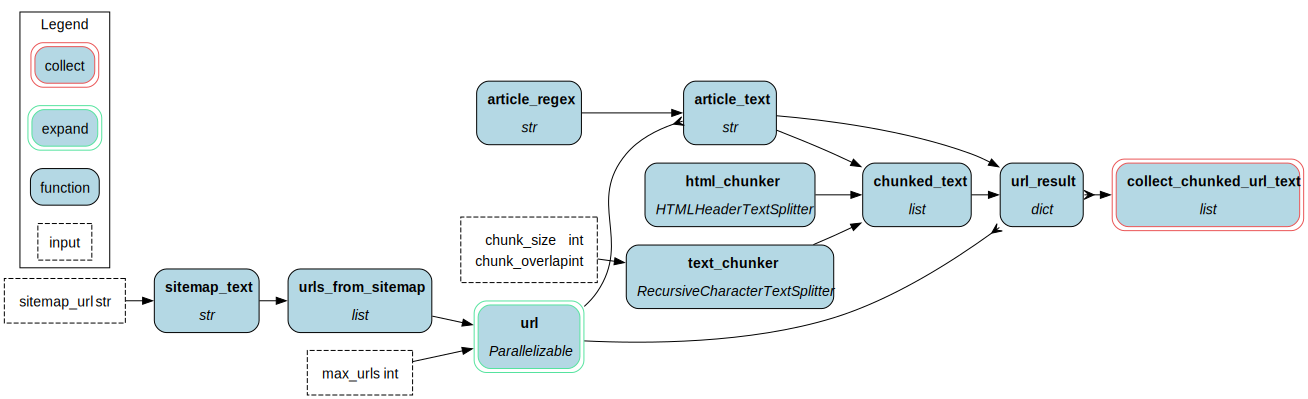

In [1]:
import doc_pipeline

from hamilton import driver
from hamilton.execution import executors

dr = (
    driver.Builder()
    .with_modules(doc_pipeline)
    .enable_dynamic_execution(allow_experimental_mode=True)
    .with_config({})
    .with_local_executor(executors.SynchronousLocalTaskExecutor())
    # Choose a backend to process the parallel parts of the pipeline
    .with_remote_executor(executors.MultiThreadingExecutor(max_tasks=5))
    # .with_remote_executor(executors.MultiProcessingExecutor(max_tasks=5))
    .build()
)
dag = dr.display_all_functions()
result = dr.execute(
    ["collect_chunked_url_text"],
    inputs={"chunk_size": 256, "chunk_overlap": 32},
)
# do something with the result...
import pprint

for chunk in result["collect_chunked_url_text"]:
    pprint.pprint(chunk)
dag

# Ray

2024-05-05 22:53:54,818	INFO worker.py:1724 -- Started a local Ray instance.


[INFO] 2024-05-05 22:53:56,010 hamilton.execution.state(417): Enqueuing 1 task: text_chunker
[INFO] 2024-05-05 22:53:56,079 hamilton.execution.state(417): Enqueuing 1 task: urls_from_sitemap
[INFO] 2024-05-05 22:53:56,080 hamilton.execution.state(417): Enqueuing 1 task: expand-url
[INFO] 2024-05-05 22:53:56,084 hamilton.execution.state(417): Enqueuing 129 tasks: expand-url.0.block-url, expand-url.1.block-url, ...
[INFO] 2024-05-05 22:53:57,939 hamilton.execution.state(417): Enqueuing 1 task: collect-url
[INFO] 2024-05-05 22:53:57,941 hamilton.execution.executors(402): Graph is done, graph state is TaskState.SUCCESSFUL
{'article_text': '<section id="airflow">\n'
                 '<h1>Airflow<a class="headerlink" href="#airflow" title="Link '
                 'to this heading">¶</a></h1>\n'
                 '<p>For more details see this <a class="reference external" '
                 'href="https://blog.dagworks.io/p/supercharge-your-airflow-dag-with">Hamilton '
                 '+ Airf

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



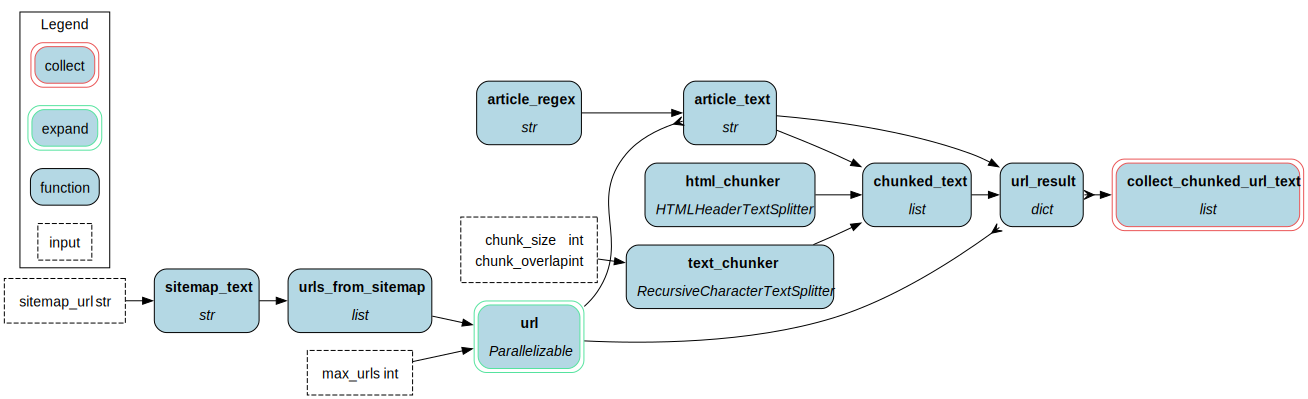

In [4]:
import logging

import doc_pipeline
import ray

from hamilton import driver, log_setup
from hamilton.plugins import h_ray

log_setup.setup_logging(logging.INFO)

dr = (
    driver.Builder()
    .with_modules(doc_pipeline)
    .enable_dynamic_execution(allow_experimental_mode=True)
    .with_config({})
    # Choose a backend to process the parallel parts of the pipeline
    # .with_remote_executor(executors.MultiThreadingExecutor(max_tasks=5))
    # .with_remote_executor(executors.MultiProcessingExecutor(max_tasks=5))
    .with_remote_executor(h_ray.RayTaskExecutor())  # be sure to run ray.init() or pass in config.
    .build()
)
dag = dr.display_all_functions()
result = dr.execute(
    ["collect_chunked_url_text"],
    inputs={"chunk_size": 256, "chunk_overlap": 32},
)
# do something with the result...
import pprint

for chunk in result["collect_chunked_url_text"]:
    pprint.pprint(chunk)

ray.shutdown()
dag

# Dask

In [5]:
import logging

import doc_pipeline
from dask import distributed

from hamilton import driver, log_setup
from hamilton.plugins import h_dask

log_setup.setup_logging(logging.INFO)

cluster = distributed.LocalCluster()
client = distributed.Client(cluster)
remote_executor = h_dask.DaskExecutor(client=client)

dr = (
    driver.Builder()
    .with_modules(doc_pipeline)
    .enable_dynamic_execution(allow_experimental_mode=True)
    .with_config({})
    # Choose a backend to process the parallel parts of the pipeline
    # .with_remote_executor(executors.MultiThreadingExecutor(max_tasks=5))
    # .with_remote_executor(executors.MultiProcessingExecutor(max_tasks=5))
    .with_remote_executor(h_dask.DaskExecutor(client=client))
    .build()
)
dag = dr.display_all_functions()
result = dr.execute(
    ["collect_chunked_url_text"],
    inputs={"chunk_size": 256, "chunk_overlap": 32},
)
# do something with the result...
import pprint

for chunk in result["collect_chunked_url_text"]:
    pprint.pprint(chunk)

client.shutdown()
dag

[INFO] 2024-05-05 22:54:07,645 hamilton.execution.state(417): Enqueuing 1 task: text_chunker
[INFO] 2024-05-05 22:54:07,709 hamilton.execution.state(417): Enqueuing 1 task: urls_from_sitemap
[INFO] 2024-05-05 22:54:07,711 hamilton.execution.state(417): Enqueuing 1 task: expand-url
[INFO] 2024-05-05 22:54:07,716 hamilton.execution.state(417): Enqueuing 129 tasks: expand-url.0.block-url, expand-url.1.block-url, ...
[INFO] 2024-05-05 22:54:09,265 hamilton.execution.state(417): Enqueuing 1 task: collect-url
[INFO] 2024-05-05 22:54:09,266 hamilton.execution.executors(402): Graph is done, graph state is TaskState.SUCCESSFUL
{'article_text': '<section id="airflow">\n'
                 '<h1>Airflow<a class="headerlink" href="#airflow" title="Link '
                 'to this heading">¶</a></h1>\n'
                 '<p>For more details see this <a class="reference external" '
                 'href="https://blog.dagworks.io/p/supercharge-your-airflow-dag-with">Hamilton '
                 '+ Airf

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

